In [1]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train (1).csv


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("train.csv")

# Preview data
df.head()


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# Check for missing values
df.isnull().sum()

# Check data types
df.dtypes


,0
Loan_ID,object
Gender,object
Married,object
Dependents,object
Education,object
Self_Employed,object
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64


In [4]:
# Fill missing categorical values with mode
for col in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    df[col].fillna(df[col].mode()[0], inplace=True)


/tmp/ipython-input-4-101086004.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


In [5]:
# Fill missing numerical values with median
for col in ['LoanAmount', 'Loan_Amount_Term']:
    df[col].fillna(df[col].median(), inplace=True)


/tmp/ipython-input-5-488147262.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


In [6]:
# Double-check for missing values
df.isnull().sum()


,0
Loan_ID,0
Gender,0
Married,0
Dependents,0
Education,0
Self_Employed,0
ApplicantIncome,0
CoapplicantIncome,0
LoanAmount,0
Loan_Amount_Term,0


In [7]:
df.drop('Loan_ID', axis=1, inplace=True)


In [8]:
from sklearn.preprocessing import LabelEncoder

label_cols = ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']

le = LabelEncoder()
for col in label_cols:
    df[col] = le.fit_transform(df[col])


In [9]:
df = pd.get_dummies(df, columns=['Property_Area', 'Dependents'], drop_first=True)


In [10]:
df.dtypes


,0
Gender,int64
Married,int64
Education,int64
Self_Employed,int64
ApplicantIncome,int64
CoapplicantIncome,float64
LoanAmount,float64
Loan_Amount_Term,float64
Credit_History,float64
Loan_Status,int64


In [11]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

# Split into training and testing (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7804878048780488

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123



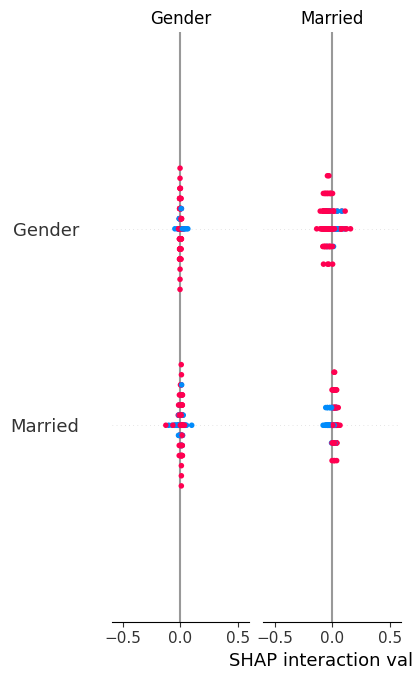

In [13]:
import shap

# Initialize explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot feature importance (summary)
shap.summary_plot(shap_values, X_test, plot_type="bar")

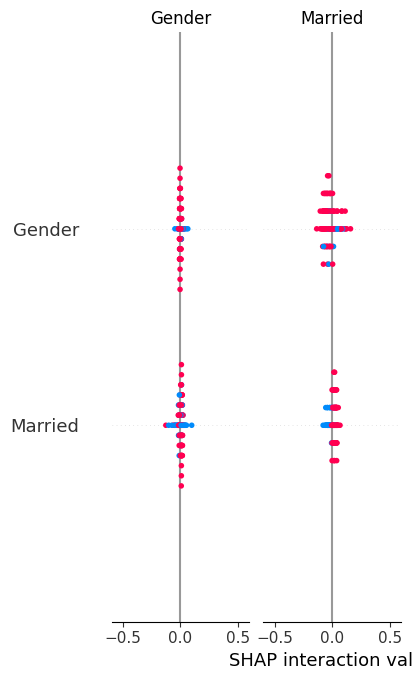

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [15]:
# Get probabilities
risk_scores = model.predict_proba(X_test)[:, 1]  # Prob of loan approval

# Scale to 0-100
risk_scores_scaled = (risk_scores * 100).round(2)

# Add to output
risk_df = X_test.copy()
risk_df['Risk_Score'] = risk_scores_scaled
risk_df['Predicted_Status'] = y_pred
risk_df.head()


,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area_Semiurban,Property_Area_Urban,Dependents_1,Dependents_2,Dependents_3+,Risk_Score,Predicted_Status
350,1,1,0,0,9083,0.0,228.0,360.0,1.0,True,False,False,False,False,77.0,1
377,1,1,0,0,4310,0.0,130.0,360.0,1.0,True,False,False,False,False,93.0,1
163,1,1,0,0,4167,1447.0,158.0,360.0,1.0,False,False,False,True,False,78.0,1
609,0,0,0,0,2900,0.0,71.0,360.0,1.0,False,False,False,False,False,72.0,1
132,1,0,0,0,2718,0.0,70.0,360.0,1.0,True,False,False,False,False,92.0,1


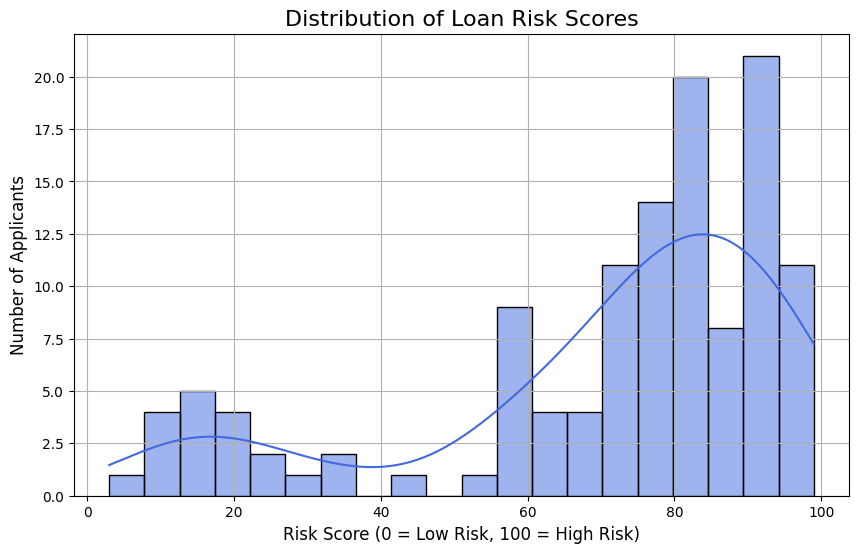

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 6))
sns.histplot(risk_scores_scaled, bins=20, kde=True, color='royalblue')

# Titles and labels
plt.title('Distribution of Loan Risk Scores', fontsize=16)
plt.xlabel('Risk Score (0 = Low Risk, 100 = High Risk)', fontsize=12)
plt.ylabel('Number of Applicants', fontsize=12)

plt.grid(True)
plt.show()
